In [1]:
from synthetic_data_generator import create_fesom_matrix 
from GNP import GNP, scale_A_by_spectral_radius
from ResGCN import ResGCN
from GMRES import GMRES
from scipy.sparse import csc_matrix, identity
import xarray as xr
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

In [2]:
mesh = xr.open_dataset("/work/ab0995/a270225/atmorep_data/multiverse/core2/original/cycle_1/fesom.mesh.diag.nc")
xcoord = mesh['lon'].values
ycoord = mesh['lat'].values
tri = mesh['face_nodes'].T.values - 1
n2d = xcoord.shape[0]

ss, ii, jj, tri, xcoord, ycoord = create_fesom_matrix(xcoord, ycoord, tri)
ds = xr.open_dataset("/work/ab0995/a270225/atmorep_data/multiverse/core2/original/cycle_1/sst.fesom.2000.nc")
data = ds['sst']
data

/home/a/a270225/.conda/envs/env-name/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.DataArray 'sst' (time: 366, nod2: 126858)> Size: 186MB
[46430028 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 3kB 2000-01-01T23:15:00 ... 2000-12-31T23:...
Dimensions without coordinates: nod2
Attributes:
    description:  sea surface temperature
    long_name:    sea surface temperature
    units:        C
    location:     node
    mesh:         fesom_mesh

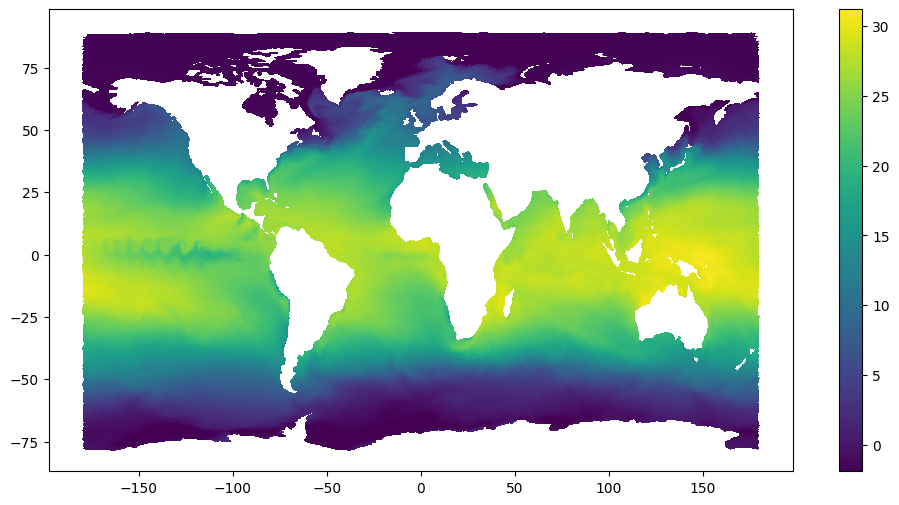

In [3]:
plt.rcParams['figure.figsize'] = [12, 6]
ok =(xcoord[tri].max(axis=1)-xcoord[tri].min(axis=1))<10 
triang = mpl.tri.Triangulation(xcoord, ycoord, tri[ok, :])

plt.tripcolor(triang, data[0, :])
plt.colorbar()

In [4]:
num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 80                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 

In [5]:
kc = 2 * math.pi / np.logspace(1, 3, 10) # 10 values from 10 to 1000 km

In [6]:
n = 1 # Filter order
device = torch.device("cuda")
solver = GMRES()
As = []

for k in kc: # Looping over the scales
    Smat1 = csc_matrix((ss * (1.0 / np.square(k)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 2.0 * (Smat1 ** n)
    A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
    A = scale_A_by_spectral_radius(A)
    As += [A]
    
data = torch.tensor(np.array(data), device=device, dtype=torch.float64)


/tmp/ipykernel_3484291/3866307710.py:9: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)


In [7]:
net = ResGCN(As[-1], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

In [ ]:
from random import randrange
iterations = np.zeros(len(As))

for i in range(len(As)):
    # Choose random sample from data
    indx = randrange(0, data.shape[0])
    ttw = data[indx, :]  - As[i] @ data[indx, :]  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=19999, progress_bar=True)
    print("Iteration " + str(iters))
    iterations[i] = iters



In [ ]:
import time 

tic = time.time()
hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs, optimizer, scheduler, num_workers=4,
    checkpoint_prefix_with_path="./tmp_", progress_bar=False)
M.net.load_state_dict(torch.load(f"./tmp_epoch_{best_epoch}.pt", map_location=device, weights_only=True))

print(f'Done. Training time: {time.time()-tic} seconds')
print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')


/home/a/a270225/.conda/envs/env-name/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
